In [4]:
import os
import random
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import seaborn as sns
import time
import shap

In [5]:
DATA_DIR = '/Users/shazarika/ProjectSpace/currentProjects/AiBEDO/codebase/aws_s3_data/CMIP6OceanHeatUptake/'

In [6]:
hfls = xr.open_dataset(DATA_DIR + 'CMIP6_allmodels.hfls.NA.piC.FFT.OHUlabel.112022.nc')
hfss = xr.open_dataset(DATA_DIR + 'CMIP6_allmodels.hfss.NA.piC.FFT.OHUlabel.112022.nc')
pr = xr.open_dataset(DATA_DIR + 'CMIP6_allmodels.pr.NA.piC.FFT.OHUlabel.112022.nc')
psl = xr.open_dataset(DATA_DIR + 'CMIP6_allmodels.psl.NA.piC.FFT.OHUlabel.112022.nc')
tas = xr.open_dataset(DATA_DIR + 'CMIP6_allmodels.tas.NA.piC.FFT.OHUlabel.112022.nc')

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


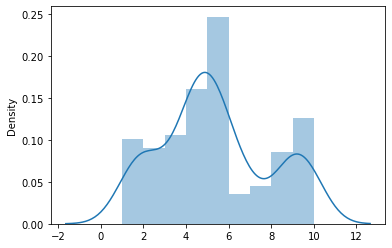

In [7]:
sns.distplot(hfls.model_OHU.data)
plt.show()

In [8]:
labels = hfls.model_OHU.data
target = pd.DataFrame(labels)

target.columns = ['labels']

In [9]:
bins = [0, 4, 8]
names = [0, 1, 2]

# 0 i low, 1 is medium, 2 is high

d = dict(enumerate(names, 1))
target['ocn_cat'] = np.vectorize(d.get)(np.digitize(target['labels'], bins))

In [10]:
target.ocn_cat.value_counts()

1    97
0    59
2    42
Name: ocn_cat, dtype: int64

In [47]:
#create mean fft arrays for all the variables
hfls_mean = np.mean(hfls.hfls.data, axis=1)[:,:,:-1]
hfss_mean = np.mean(hfss.hfss.data, axis=1)[:,:,:-1]
pr_mean = np.mean(pr.pr.data, axis=1)[:,:,:-1]
psl_mean = np.mean(psl.psl.data, axis=1)[:,:,:-1]
tas_mean = np.mean(tas.tas.data, axis=1)[:,:,:-1]


In [48]:
pr_mean.shape

(198, 36, 110)

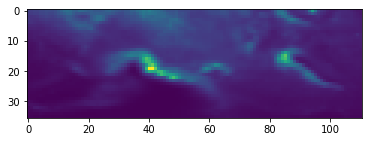

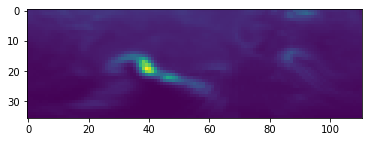

In [12]:
plt.imshow(pr_mean[0])
plt.show()


plt.imshow(pr_mean[100])
plt.show()


#### Spatial Analysis

In [255]:
LON_Y = pr_mean.shape[1]
LAT_X = pr_mean.shape[2]

#size of each partition
y_step = 9
x_step = 5

#create ids of each partitions to remap results
partition_id_list = []
for y in range(0,LON_Y, y_step):
    for x in range(0, LAT_X, x_step):
        y_start = y
        y_end = y + y_step if y + y_step < LON_Y else LON_Y
        x_start = x
        x_end = x + x_step if x + x_step < LAT_X else LAT_X
        y_list = np.arange(y_start, y_end)
        x_list = np.arange(x_start, x_end)
        partition_id_list.append([y_list,x_list])
        
#extract the avg values for each partition
hfls_partition_avg = []
hfss_partition_avg = []
pr_partition_avg = []
psl_partition_avg = []
tas_partition_avg = []
for p in partition_id_list:
    hfls_partition_avg.append(np.mean(hfls_mean[:,p[0][0]:p[0][-1]+1, p[1][0]:p[1][-1]+1],  axis=(1,2)))
    hfss_partition_avg.append(np.mean(hfss_mean[:,p[0][0]:p[0][-1]+1, p[1][0]:p[1][-1]+1],  axis=(1,2)))
    pr_partition_avg.append(np.mean(pr_mean[:,p[0][0]:p[0][-1]+1, p[1][0]:p[1][-1]+1],  axis=(1,2)))
    psl_partition_avg.append(np.mean(psl_mean[:,p[0][0]:p[0][-1]+1, p[1][0]:p[1][-1]+1],  axis=(1,2)))
    tas_partition_avg.append(np.mean(tas_mean[:,p[0][0]:p[0][-1]+1, p[1][0]:p[1][-1]+1],  axis=(1,2)))

In [256]:
len(partition_id_list)

88

In [257]:
#remap partition to full grid
def map_to_full_array(part_id_list, part_val_list):
    recon_array = np.zeros((LON_Y,LAT_X))
    for i, p in enumerate(part_id_list):
        recon_array[p[0][0]:p[0][-1]+1, p[1][0]:p[1][-1]+1] = part_val_list[i]
    return recon_array
    

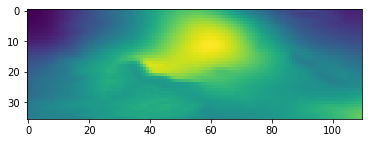

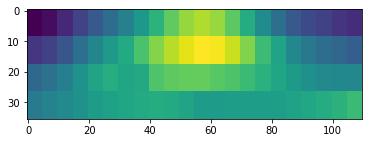

In [258]:
##test
plt.imshow(psl_mean[100])
plt.show()

r_array = map_to_full_array(partition_id_list, np.array(psl_partition_avg)[:,100])
plt.imshow(r_array)
plt.show()


#### Build models for single variable along with the spatial context
- picked 'psl' since it was the most important in previous single location analysis

In [259]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_psl = scaler.fit(np.array(psl_partition_avg).reshape(-1, 1))
norm_psl = scaler_psl.transform(np.array(psl_partition_avg).reshape(-1, 1)).reshape(np.array(psl_partition_avg).shape)

In [260]:
#generate partition id name list
partition_id_names = []
for i in range(len(partition_id_list)):
    partition_id_names.append("pid_"+ f'{i:03d}')

In [261]:
full_data_df = pd.DataFrame(norm_psl.T, columns=partition_id_names)

datalist = (full_data_df, target['ocn_cat'].values)

In [262]:
X_train,X_test,Y_train,Y_test = train_test_split(*datalist, test_size=0.2, random_state=0)

In [263]:
def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

#### KNN classifier

In [264]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X_train, Y_train)

print_accuracy(knn.predict)

Accuracy = 82.5%


#### Linear SVM

In [171]:
svc_linear = sklearn.svm.SVC(kernel='linear', probability=True)
svc_linear.fit(X_train, Y_train)

print_accuracy(svc_linear.predict)

Accuracy = 65.0%


#### RBF SVM

In [173]:
svc_rbf = sklearn.svm.SVC(kernel='rbf', probability=True)
svc_rbf.fit(X_train, Y_train)
print_accuracy(svc_rbf.predict)

Accuracy = 75.0%


#### Logistic Regression

In [174]:
linear_lr = sklearn.linear_model.LogisticRegression()
linear_lr.fit(X_train, Y_train)
print_accuracy(linear_lr.predict)

Accuracy = 70.0%


#### Decision Tree

In [175]:
dtree = sklearn.tree.DecisionTreeClassifier(min_samples_split=2)
dtree.fit(X_train, Y_train)
print_accuracy(dtree.predict)

Accuracy = 85.0%


#### Rand Forest

In [265]:
rforest = sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
rforest.fit(X_train, Y_train)
print_accuracy(rforest.predict)

Accuracy = 77.5%


#### MLP

In [266]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(10, 2), random_state=0)
nn.fit(X_train, Y_train)
print_accuracy(nn.predict)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


Accuracy = 85.0%


#### SHAP explainer

In [267]:
shap.initjs()

In [284]:
explainer = shap.KernelExplainer(knn.predict_proba, X_train)
# baseline expected values based on the trainset
print("expected vals:", explainer.expected_value)

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
Using 158 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


expected vals: [0.2835443  0.46835443 0.24810127]


2


,pid_000,pid_001,pid_002,pid_003,pid_004,pid_005,pid_006,pid_007,pid_008,pid_009,...,pid_078,pid_079,pid_080,pid_081,pid_082,pid_083,pid_084,pid_085,pid_086,pid_087
109,0.063544,0.072899,0.098405,0.126403,0.147448,0.174446,0.21394,0.263664,0.320473,0.365363,...,0.475389,0.518824,0.554367,0.575909,0.585066,0.59007,0.597239,0.60558,0.606784,0.608894


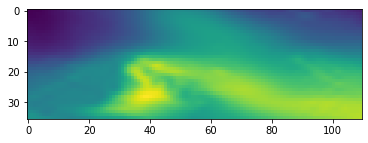

In [289]:
##identify which input id to explain fron the prepared data

print(Y_test[20])
plt.imshow(psl_mean[109])
X_test.iloc[[20]]

In [288]:
#model prediction
model_prediction = knn.predict_proba(X_test.iloc[20,:].values.reshape(-1,1).T)
print("model prediction:", model_prediction)

model prediction: [[0.  0.2 0.8]]


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


In [290]:
#explain single value
individual_shap_values = explainer.shap_values(X_test.iloc[20,:])

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To 

In [291]:
my_exp = shap.Explanation(individual_shap_values,explainer.expected_value, feature_names=X_test.columns)

In [292]:
shap.force_plot(explainer.expected_value[2], individual_shap_values[2], X_test.iloc[22,:])

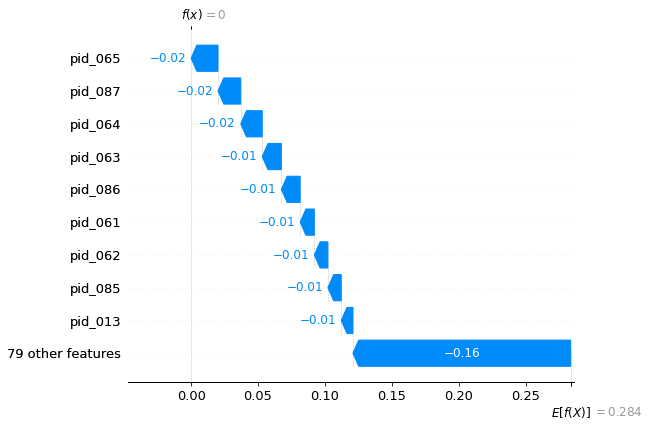

In [294]:
shap.plots.waterfall(my_exp[0])

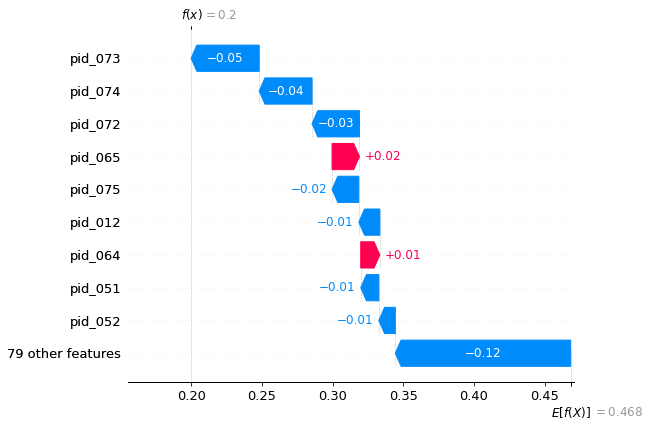

In [295]:
shap.plots.waterfall(my_exp[1])

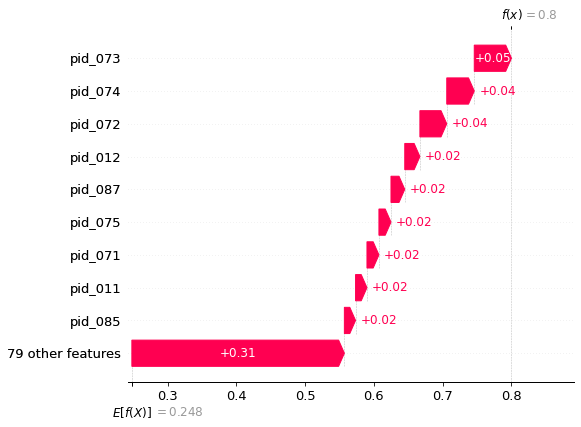

In [293]:
shap.plots.waterfall(my_exp[2])

#### remap explanation to spatial domain

In [308]:
shap_mapped_array_list = []
for i in range(3):
    shap_mapped_array_list.append(map_to_full_array(partition_id_list, individual_shap_values[i]))


In [313]:
import proplot as pplt

In [340]:

lat_vals = psl.lat.data
lon_vals = psl.lon.data[:-1]


lonv, latv = np.meshgrid(lon_vals, lat_vals)

In [368]:
shap_mapped_array_list[2].shape

(36, 110)

Text(0.5, 0.98, 'SHAP based spatial XAI for psl variable.\n Model Prediction= High Ocean heat uptake')

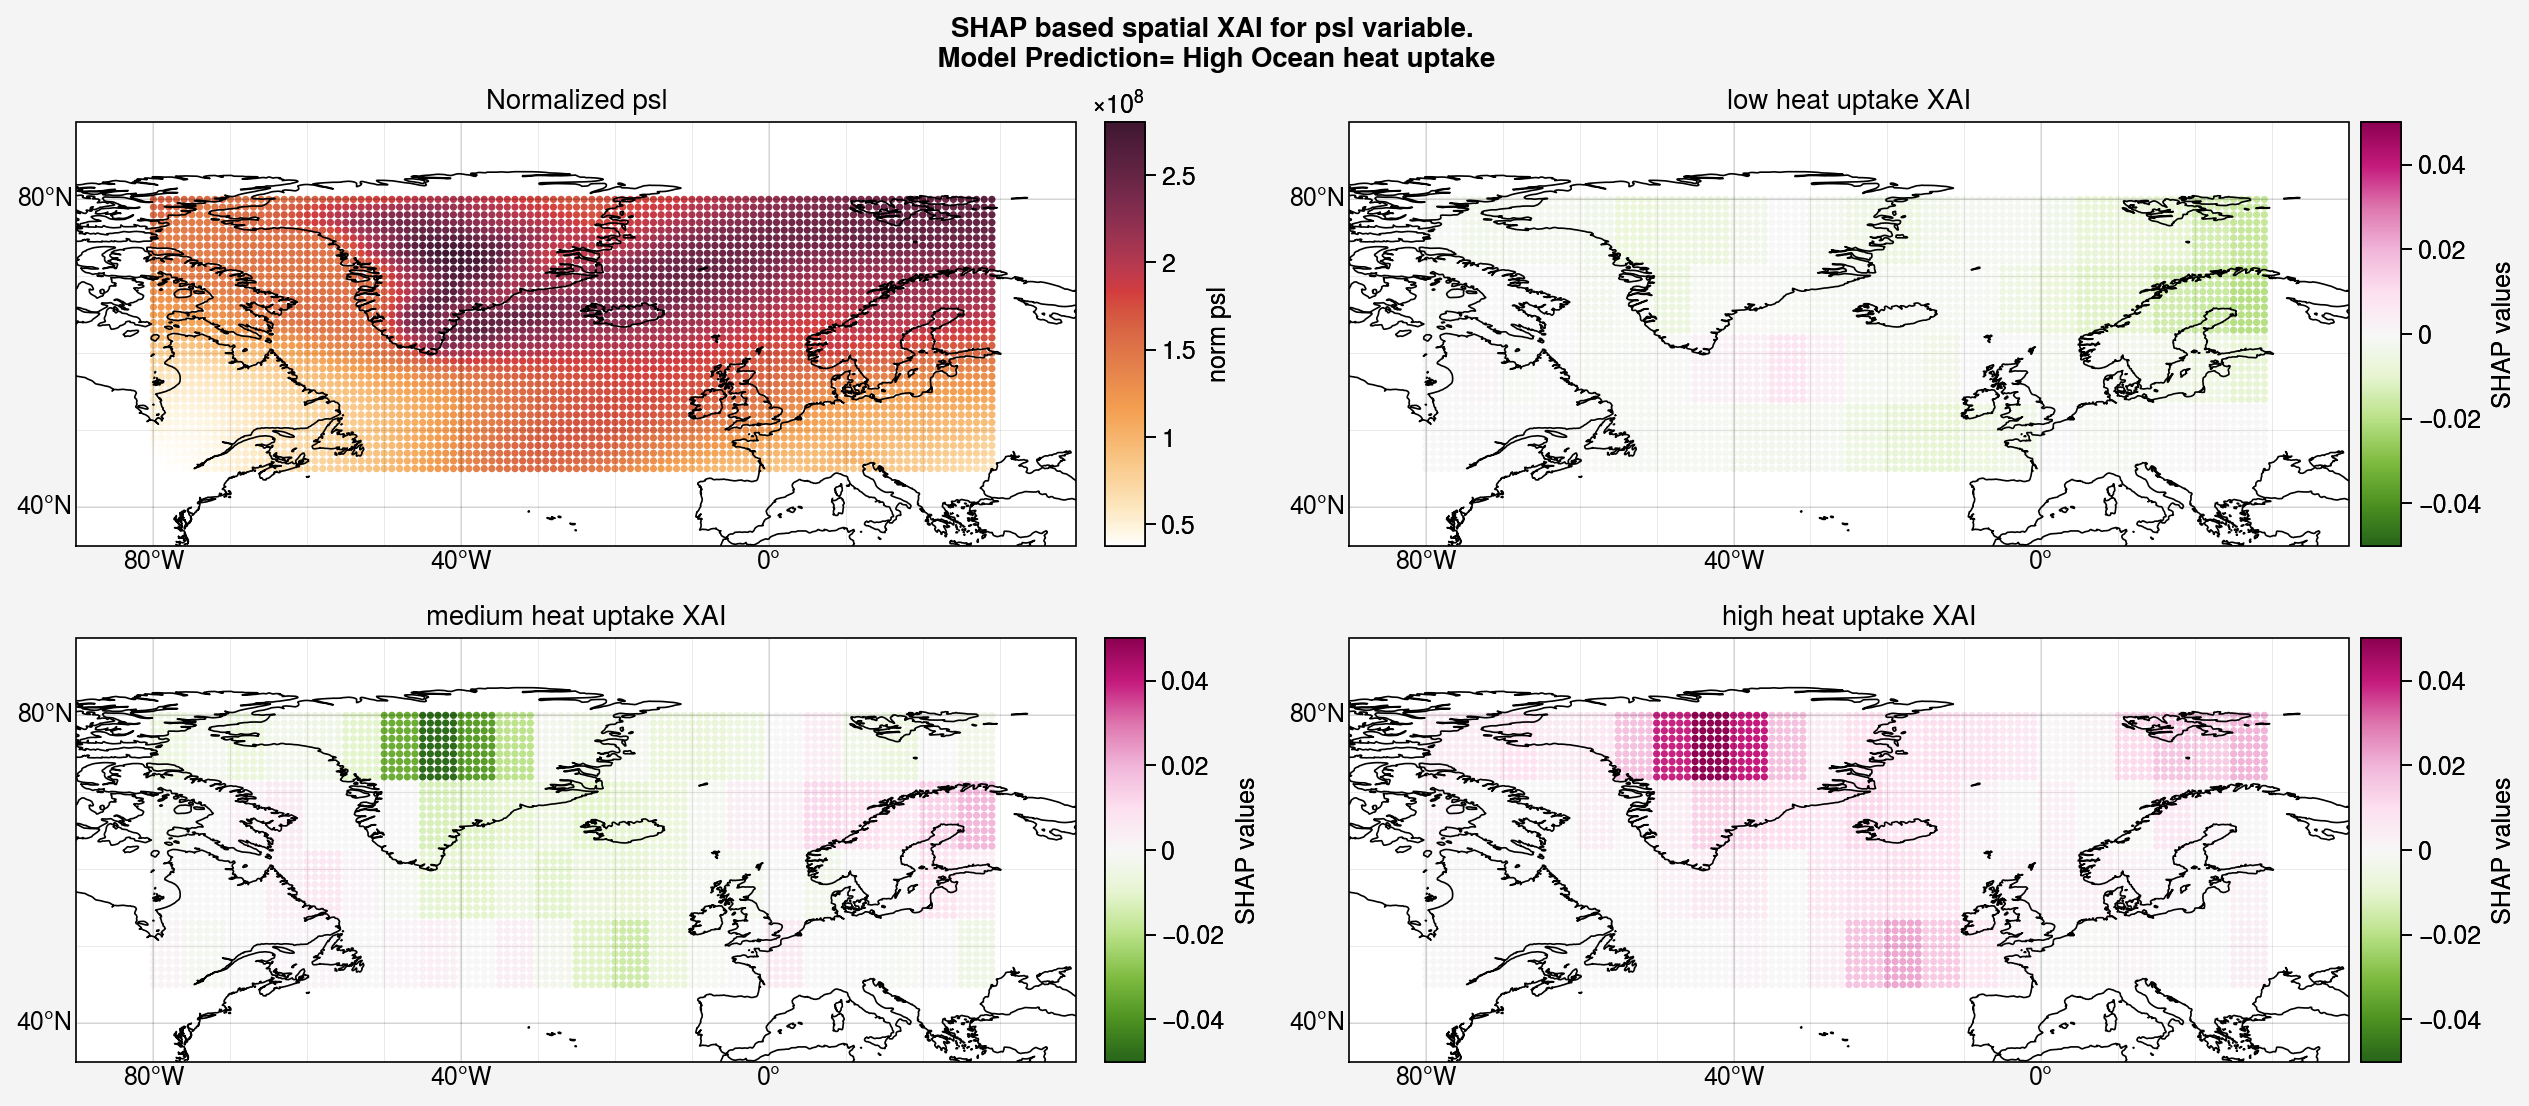

In [405]:
fig,axes = pplt.subplots(nrows=2,ncols=2,proj='cyl', refwidth=5)

fig.format(coast=True)
axes.format(
    lonlim=(-90, 40), latlim=(35, 90), labels=True,lonlines=40, latlines=40,
    gridminor=True
)
vmax = 0.05
m00 = axes[0,0].scatter(lonv.flatten(),latv.flatten(),c = psl_mean[109].flatten(), s= 4)
m01 = axes[0,1].scatter(lonv.flatten(),latv.flatten(),c = shap_mapped_array_list[0].flatten(), vmax=vmax,vmin=-vmax, s= 4, cmap = 'PiYG_r')
m02 = axes[1,0].scatter(lonv.flatten(),latv.flatten(),c = shap_mapped_array_list[1].flatten(), vmax=vmax,vmin=-vmax, s= 4, cmap = 'PiYG_r')
m03 = axes[1,1].scatter(lonv.flatten(),latv.flatten(),c = shap_mapped_array_list[2].flatten(), vmax=vmax,vmin=-vmax, s= 4, cmap = 'PiYG_r')

axes[0,0].format(title='Normalized psl')
axes[0,1].format(title='low heat uptake XAI')
axes[1,0].format(title='medium heat uptake XAI')
axes[1,1].format(title='high heat uptake XAI')

axes[0,0].colorbar(m00, loc='r', label='norm psl')
axes[0,1].colorbar(m01, loc='r', label='SHAP values')
axes[1,0].colorbar(m02, loc='r', label='SHAP values')
axes[1,1].colorbar(m03, loc='r', label='SHAP values')

fig.suptitle('SHAP based spatial XAI for psl variable.\n Model Prediction= High Ocean heat uptake')

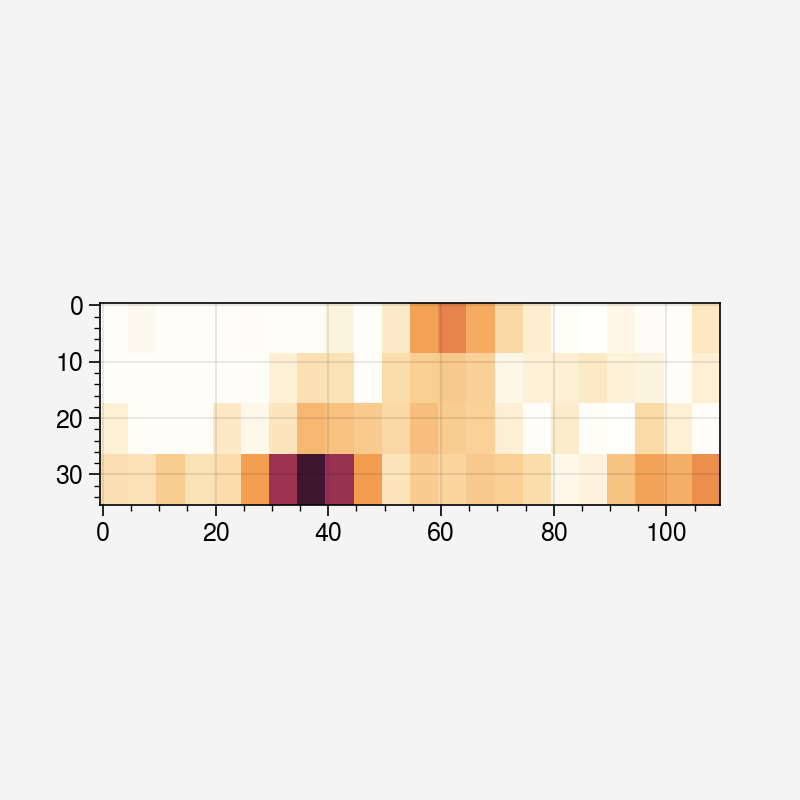

In [366]:
plt.imshow(shap_mapped_array_list[2])

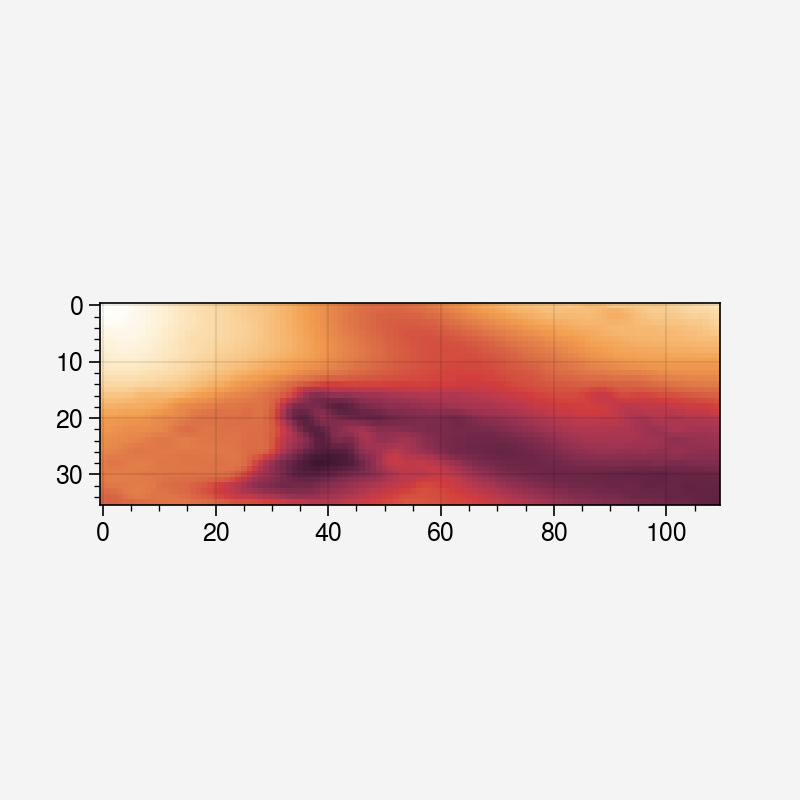

In [367]:
plt.imshow(psl_mean[109])